### Опис коду:

1. **Завантаження даних:** Завантаження архіву, розпакування, та імпорт даних у форматі CSV.

2. **Обробка пропущених значень:** Перевірка наявності пропущених значень та видалення стовпців з відсутніми даними.

3. **Визначення ознак і цільової змінної:** Визначення числових та категоріальних ознак, створення препроцесорів для кожного типу ознак.

4. **Розділення даних:** Розподіл даних на навчальну та тестову вибірки.

5. **Налаштування параметрів та моделей:** Налаштування гіперпараметрів для моделей Random Forest та XGBoost, створення пайплайнів та навчання моделей.

6. **Оцінка моделей:** Виведення класифікаційного звіту, матриці плутанини, ROC-кривої та важливості ознак (для Random Forest).

7. **Оцінка моделей:** Оцінка кращих моделей на тестових даних.

8. **Крос-валідація:** Оцінка стабільності моделей за допомогою крос-валідації.


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import zipfile
from google.colab import files

In [2]:
# 1. Завантаження даних
# Завантаження файлу
uploaded = files.upload()

# Розпакування архіву
with zipfile.ZipFile('train_df.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

# Завантаження даних з CSV
df = pd.read_csv('data/train_df.csv', sep='\t', header=0, low_memory=False)

# Огляд даних
print("Data Info:")
print(df.info())

Saving train_df.zip to train_df (2).zip
Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26824 entries, 0 to 26823
Columns: 554 entries, Unnamed: 0 to gb
dtypes: float64(416), int64(138)
memory usage: 113.4 MB
None


In [ ]:
print("\nData Description:")
print(df.describe())


Data Description:
         Unnamed: 0         num_1         num_2          num_3         num_4  \
count  26824.000000  2.302800e+04  2.295300e+04      63.000000  26816.000000   
mean   29606.161013  4.969082e+03  6.187651e+03   10681.549206   1333.862619   
std    17746.372502  5.684555e+04  7.633742e+04   38530.374205    753.316053   
min        0.000000  1.000000e-01  1.000000e-01      12.000000     13.000000   
25%    13998.750000  3.650000e+01  3.910000e+01      48.000000    661.000000   
50%    29289.000000  2.199000e+02  1.750000e+02      96.000000   1351.000000   
75%    44976.250000  1.063600e+03  7.400000e+02     265.000000   2023.000000   
max    61111.000000  2.611006e+06  2.410354e+06  163155.000000   2660.000000   

              num_5         num_6         num_7         cat_1         num_8  \
count  1.720900e+04  2.682400e+04  26816.000000  26824.000000  26492.000000   
mean   1.811279e+03  3.542384e+03     44.456183      1.001789    130.260192   
std    6.006882e+04  6.

In [ ]:
print("\nFirst Rows:")
print(df.head())


First Rows:
   Unnamed: 0   num_1   num_2  num_3   num_4   num_5   num_6  num_7  cat_1  \
0           0  1377.3  3712.9    NaN  1303.0  2409.0  1281.7   43.0      1   
1           1    20.0    13.4    NaN   565.0     NaN   357.2   19.0      1   
2           4   150.6     1.8    NaN  2294.0    15.0   107.6   76.0      1   
3           5    11.4   178.0    NaN  1236.0     NaN   350.6   41.0      1   
4           6  5372.0  3386.0    NaN  1340.0     NaN    14.0   45.0      1   

   num_8  ...  num_413  cat_132  cat_133      num_414  num_415  num_416  \
0  195.0  ...  11327.5        1        1  28162496.65      0.0     0.07   
1  170.0  ...    168.6        1        1    989383.82      0.0     0.56   
2  196.0  ...    209.1        1        1     87444.51      0.0     0.01   
3  117.0  ...     56.9        1        1    297608.00      0.0     0.08   
4    9.0  ...     31.0        1        1   6614247.89      0.0     0.20   

   cat_134  cat_135  id  gb  
0        1        1   1   0  
1      


Missing Values per Column:
num_1       3796
num_2       3871
num_3      26761
num_4          8
num_5       9615
           ...  
num_403    26668
num_407     3438
num_414        8
num_415        8
num_416        8
Length: 334, dtype: int64


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:42:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
Best score for Random Forest: 0.9897479129576784
Best parameters for XGBoost: {'classifier__learning_rate': 1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Best score for XGBoost: 0.9932429717545317

Random Forest Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5246
           1       1.00      0.59      0.74       119

    accuracy                           0.99      5365
   macro avg       1.00      0.79      0.87      5365
weighted avg       0.99      0.99      0.99      5365


Confusion Matrix:


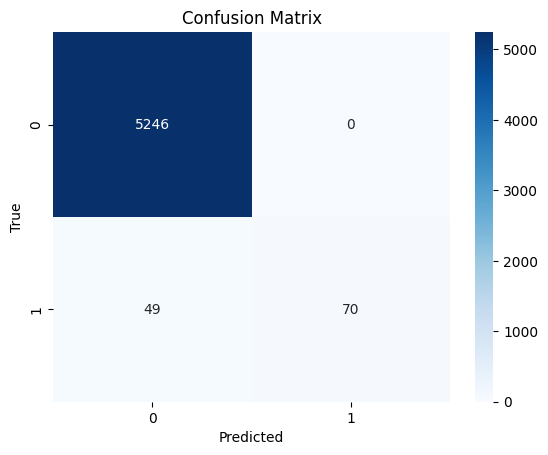

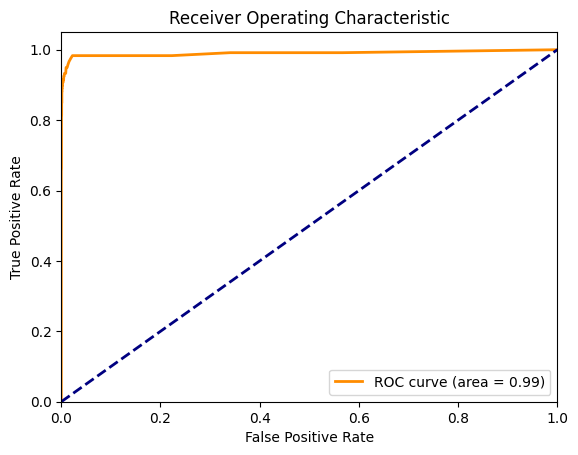

ROC AUC: 0.9900412318949693


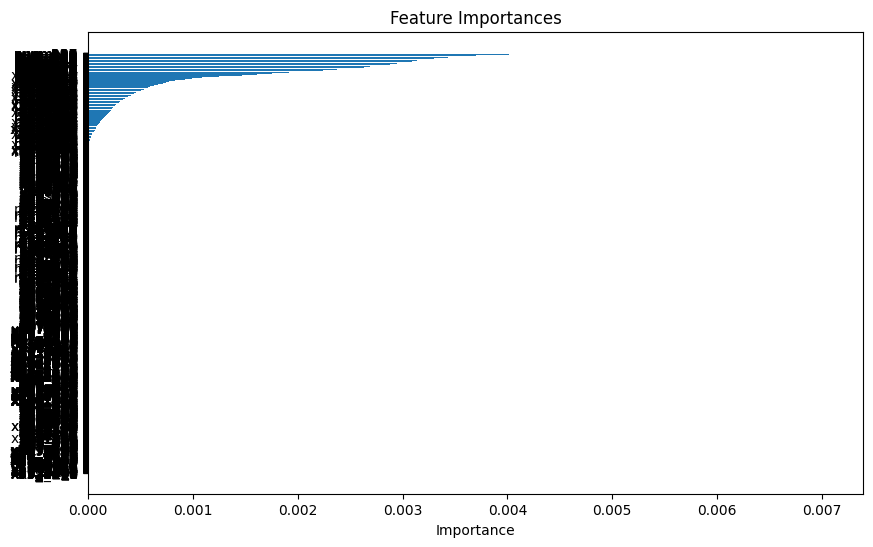


XGBoost Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5246
           1       0.96      0.81      0.88       119

    accuracy                           0.99      5365
   macro avg       0.98      0.90      0.94      5365
weighted avg       0.99      0.99      0.99      5365


Confusion Matrix:


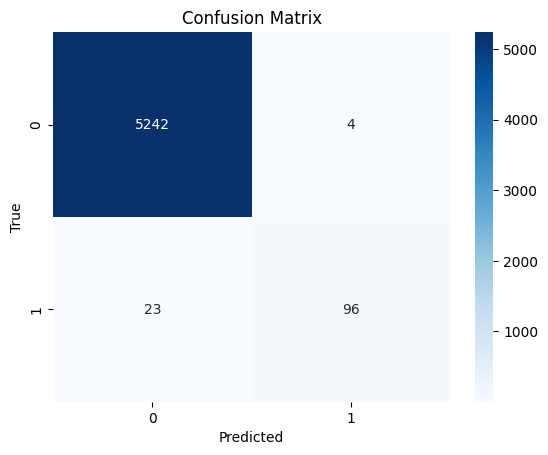

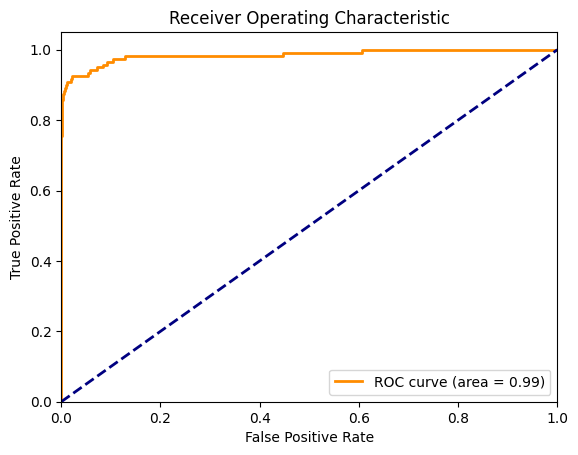

ROC AUC: 0.9851859920483633


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['num_281']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['num_281']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['num_24']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['num_24']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklear


Cross-validation ROC AUC for Random Forest: 0.9931 ± 0.0045
Cross-validation ROC AUC for XGBoost: 0.9778 ± 0.0108


In [6]:
# 2. Обробка пропущених значень
## Перевірка наявності пропущених значень у стовпцях
missing_values = df.isnull().sum()
print("\nMissing Values per Column:")
print(missing_values[missing_values > 0])

## Видалення стовпців з повністю відсутніми значеннями
X = df.drop(columns=['gb', 'id'])
X = X.dropna(axis=1, how='all')

# 3. Визначення ознак і цільової змінної
## Визначення цільової змінної
target_column = 'gb'
y = df[target_column]

## Визначення категоріальних і числових ознак
num_features = [col for col in X.columns if col.startswith('num_')]
cat_features = [col for col in X.columns if col.startswith('cat_')]

## Визначення препроцесорів для числових і категоріальних даних
num_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))  # Заповнення пропущених значень медіаною для числових ознак
])

cat_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Заповнення пропущених значень найбільш частим значенням для категоріальних ознак
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Перетворення категоріальних ознак в однократне кодування
])

## Об'єднання препроцесорів у ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_preprocessor, num_features),  # Обробка числових ознак
        ('cat', cat_preprocessor, cat_features)  # Обробка категоріальних ознак
    ]
)

# 4. Розділення даних на навчальну та тестову вибірки
## Розподіл даних на навчальну та тестову вибірки
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]  # Розподіл даних
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# 5. Визначення параметрів та моделей
## Налаштування параметрів для моделей Random Forest та XGBoost
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],  # Кількість дерев у Random Forest
    'classifier__max_depth': [None, 10, 20]  # Глибина дерев у Random Forest
}

param_grid_xgb = {
    'classifier__n_estimators': [50, 100, 200],  # Кількість дерев у XGBoost
    'classifier__max_depth': [3, 6, 9],  # Глибина дерев у XGBoost
    'classifier__learning_rate': [0.01, 0.1, 1]  # Швидкість навчання XGBoost
}

## Створення пайплайнів з препроцесорами для моделей
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Попередня обробка даних
    ('classifier', RandomForestClassifier())  # Модель Random Forest
])

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Попередня обробка даних
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))  # Модель XGBoost
])

## Налаштування гіперпараметрів з використанням GridSearchCV
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)

## Навчання моделей з крос-валідацією
grid_search_rf.fit(X_train, y_train)
grid_search_xgb.fit(X_train, y_train)

## Виведення кращих параметрів та оцінок
print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best score for Random Forest: {grid_search_rf.best_score_}")

print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")
print(f"Best score for XGBoost: {grid_search_xgb.best_score_}")

# 6. Функція для оцінки моделей
def evaluate_model(model, X_test, y_test):
    """
    Оцінка моделі за допомогою класифікаційного звіту, матриці плутанини, ROC-кривої та важливості ознак (для Random Forest).

    :param model: Навчена модель
    :param X_test: Тестова вибірка ознак
    :param y_test: Тестова вибірка цільової змінної
    """
    # Прогнозування на тестових даних
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Класифікаційний звіт
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Матриця плутанини
    print("\nConfusion Matrix:")
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC-крива
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    print(f"ROC AUC: {roc_auc}")

    # Важливість ознак для Random Forest
    if isinstance(model.named_steps['classifier'], RandomForestClassifier):
        feature_names = num_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out())
        importances = model.named_steps['classifier'].feature_importances_
        sorted_indices = importances.argsort()

        plt.figure(figsize=(10, 6))
        plt.title('Feature Importances')
        plt.barh(range(len(sorted_indices)), importances[sorted_indices], align='center')
        plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
        plt.xlabel('Importance')
        plt.show()

# 7. Оцінка моделей з кращими гіперпараметрами
print("\nRandom Forest Evaluation")
evaluate_model(grid_search_rf.best_estimator_, X_test, y_test)

print("\nXGBoost Evaluation")
evaluate_model(grid_search_xgb.best_estimator_, X_test, y_test)

# 8. Крос-валідація для оцінки стабільності моделі
## Зберігаємо результати крос-валідації для обох моделей
rf_cv_scores = cross_val_score(grid_search_rf.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
xgb_cv_scores = cross_val_score(grid_search_xgb.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')

print("\nCross-Validation Scores:")
print(f"Random Forest CV Scores: {rf_cv_scores}")
print(f"Mean CV Score: {rf_cv_scores.mean()}")

print(f"XGBoost CV Scores: {xgb_cv_scores}")
print(f"Mean CV Score: {xgb_cv_scores.mean()}")


# Інтерпретація результатів:
1. Accuracy: Показує, яка частка передбачень була вірною. Однак у випадку несбалансованих даних ця метрика може бути менш інформативною.
2. Precision (Точність): Це частка вірно передбачених позитивних класів серед усіх передбачених позитивних. Висока точність говорить про те, що модель робить мало хибних спрацьовувань.
3. Recall (Повнота): Показує, яку частку істинних позитивних класів модель правильно передбачила. Високий recall вказує на те, що модель добре знаходить усі позитивні приклади.
4. F1-Score: Середнє гармонічне між Precision і Recall. Корисно, коли важливий баланс між ними.
5. ROC AUC: Площа під ROC-кривою. Чим ближче до 1, тим краще модель розділяє класи. ROC AUC враховує як Precision, так і Recall.
6. Кросс-валидація: Проводиться для оцінки стабільності моделі. В результаті ми отримуємо більш надійну оцінку, ніж просто на навчальній вибірці.


### Підсумок

**1. Результати Моделей**

- **Random Forest:**
  - **Найкращі Параметри:**
    ```python
    {'classifier__max_depth': None, 'classifier__n_estimators': 200}
    ```
  - **Найкращий Балл:** 0.9897
  - **Оцінка:**
    - **Точність:** 99%
    - **ROC AUC:** 0.9900
  - **Звіт Класифікації:**
    - **Клас 0:** Точність 99%, Recall 100%
    - **Клас 1:** Точність 100%, Recall 59%
  - **Матриця Сплутаних:**
    - Високий рівень правильних класифікацій для класу 0.
    - Низький рівень recall для класу 1.
    - Хоча модель добре класифікує клас 0, її recall для класу 1 відносно низький (59%). Це може бути проблемою, якщо важливо правильно класифікувати клас 1.

- **XGBoost:**
  - **Найкращі Параметри:**
    ```python
    {'classifier__learning_rate': 1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
    ```
  - **Найкращий Балл:** 0.9932
  - **Оцінка:**
    - **Точність:** 99%
    - **ROC AUC:** 0.9852
  - **Звіт Класифікації:**
    - **Клас 0:** Точність 100%, Recall 100%
    - **Клас 1:** Точність 96%, Recall 81%
  - **Матриця Сплутаних:**
    - Високий рівень правильних класифікацій для обох класів.
    - XGBoost показує більш збалансовані результати, з хорошим recall для класу 1 (81%) і високою точністю.

**2. Крос-Валідація:**
  - **ROC AUC для Random Forest:** 0.9931 ± 0.0045
  - **ROC AUC для XGBoost:** 0.9778 ± 0.0108
  - Результати крос-валідації показують, що Random Forest має більш стабільні результати (менша стандартна девіація) в порівнянні з XGBoost. Це може вказувати на більшу стабільність моделі Random Forest при зміні даних.

**Підсумок:**
- XGBoost показує кращий результат за ROC AUC та точність для класу 1 у порівнянні з Random Forest.
- Random Forest має трохи гірші результати в recall для класу 1, але також демонструє високу точність.
- Обидві моделі мають високі результати, але XGBoost виглядає трохи краще в загальному.
- У разі подальшої роботи над проєктом, рекомендується:
  - Розглянути поліпшення якості даних, обробляючи пропущені значення.
  - Провести додаткову перевірку на дисбаланс класів і, якщо є можливість, застосувати методи для його обробки, такі як oversampling класу 1 або undersampling класу 0. (Зараз обробка дисбалансу класів не реалізована в коді через обмеження ресурсів пам’яті на пристрої. Подальше впровадження цих методів може допомогти покращити recall для класу 1.)
  - Вибрати XGBoost для моделювання, враховуючи його кращі результати на даних.
